
First we specify some data augmentations with [Transforms V2](https://pytorch.org/vision/stable/auto_examples/plot_transforms_v2.html) for both the training and testing sets. The following transforms are applied to the `train_transform` object:

- `RandomRotation`: Rotates the image between 0 and 30 degrees
  
- `RandomHorizontalFlip`: Randomly flips an image along the horizontal axis
  
- `ToImageTensor`: transforms input image into a `torch.Tensor`
  
- `ConvertImageDtype`: converts elements in tensors to `float32` dtype – necessary for development on M-series MacBooks.
  
- `Normalize`: Normalize tensor values such that the mean and standard deviation of the images become `0.0` and `1.0` respectively. Per-color mean and standard deviation values were calculated w.r.t. this [guide](https://saturncloud.io/blog/how-to-normalize-pytorch-cifar10-images-for-improved-model-performance/).

We instantiate an `unaugmented_transform` object as well to create test and validation validation datasets without any augmentations.

In [ ]:
import torch
from torch import mps
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

# previously calculated normalization values
mean = [0.4934569299, 0.483376652, 0.4471793473]
std = [0.2476211786, 0.2445851415, 0.2626110017]

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

unaugmented_transform = transforms.Compose(
    [
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

Torch Device: mps


We next download the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) from the pytorch website and apply the transforms. The `unaugumented_set` is 50/50 split into a `test_set` and `val_set` using the `random_split` utility.

In [ ]:
import torchvision.datasets as datasets
from torch.utils.data import random_split

train_set = datasets.CIFAR10("./Misc_files/data", train=True, transform=train_transform, download=True)

unaugmented_set = datasets.CIFAR10("./Misc_files/data", train=False, transform=unaugmented_transform, download=True)

test_set, val_set = random_split(unaugmented_set, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


The train, test, and validation sets are then passed to a `Dataloader` iterable with a common practice `batch_size` of 64:

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 64, shuffle=False)

With the datasets finalized we can additionally view some sample instances of the data. Plotting instances of the training set can additionally show the results of of the data augmentations (`RandomRotation` is apparent).

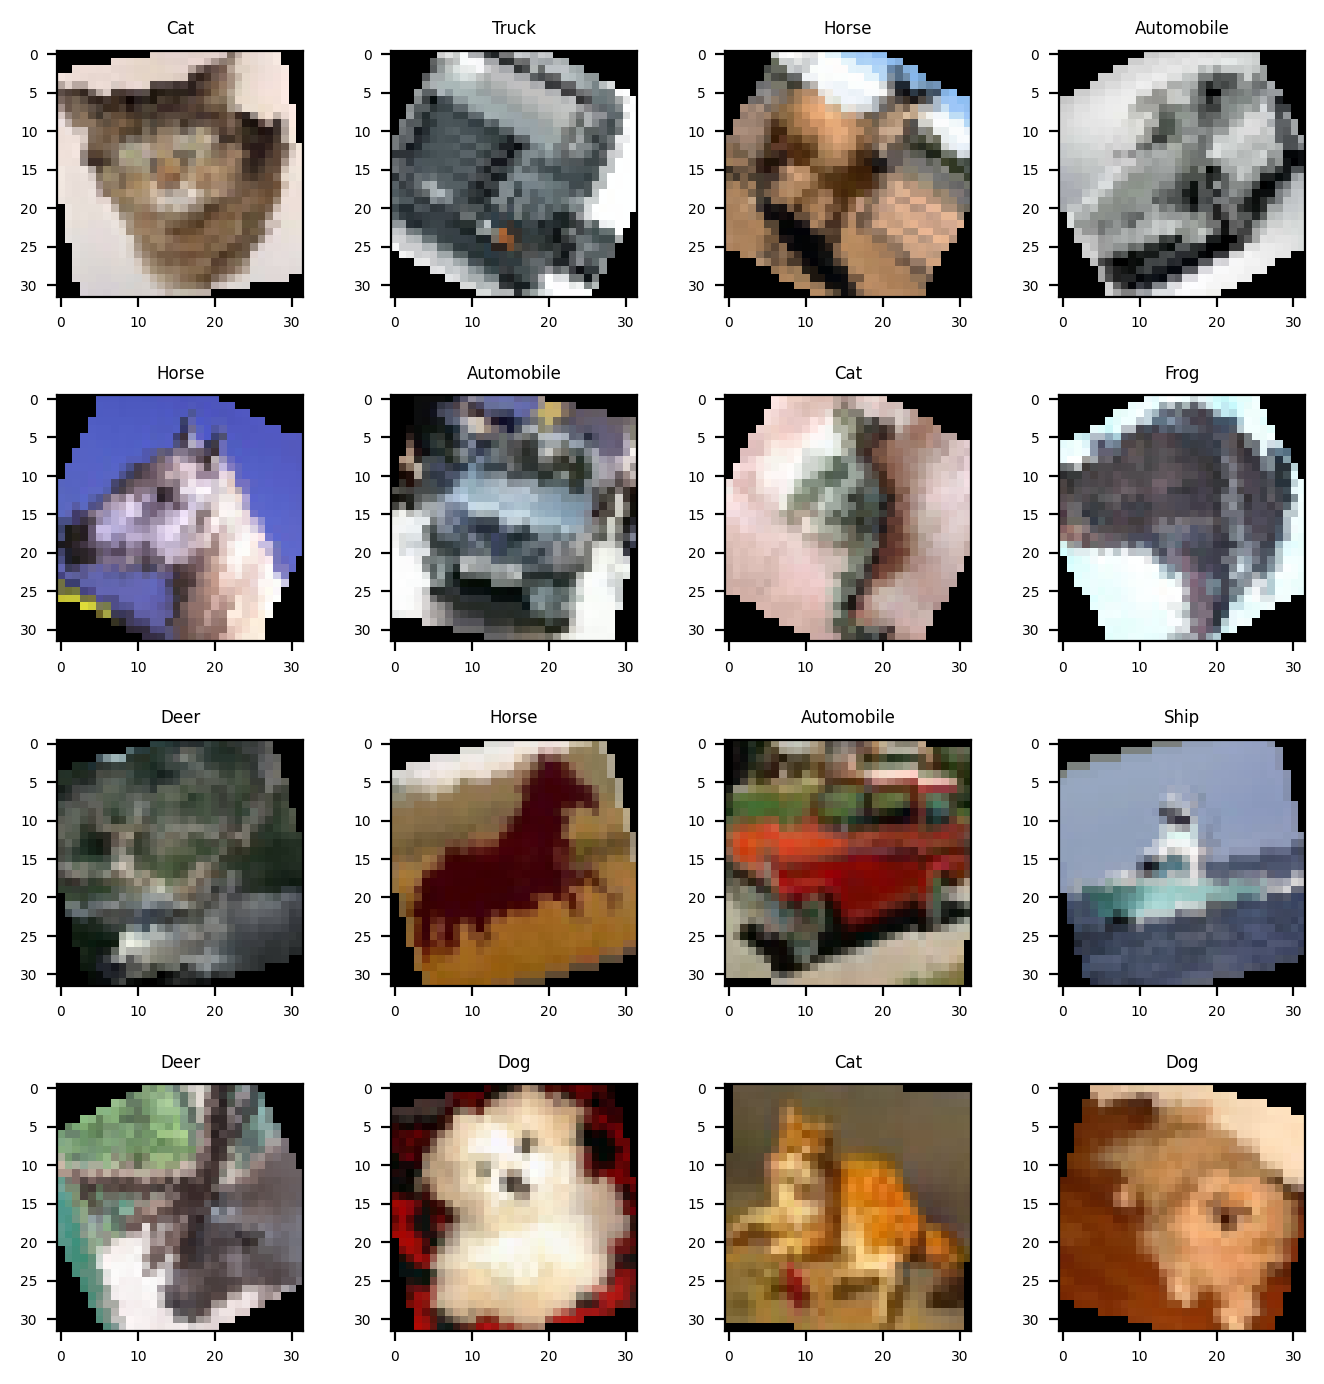

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

CIFAR10_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

images, labels = next(iter(train_loader))

# Define plot size and DPI
fig = plt.figure(figsize=(8, 8), dpi=200)

# Adjust space between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(CIFAR10_labels.get(int(labels[i])))
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1.)
    plt.imshow(img)

plt.show()

Using torch's `nn` module, we can create a logisitic regression model comprised of the following layers:
1. A `ReLU` layer that serves as the activation for `ResNet18`'s last linear layer.
2. A `Linear` layer whose output corresponds to the 10 categories in the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html).

We can additionally specify the loss `criterion` and `optimizer` algorithm for our training loop.
- `CrossEntropyLoss()` loss function was selected to train classification with _C_ classes.
- `Adam` optmizer was selected due to it's performant qualities while training.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

# create transfer learning model
resnet18_based = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in resnet18_based.parameters():
    param.requires_grad = False

num_ftrs = resnet18_based.fc.in_features
resnet18_based.fc = nn.Linear(num_ftrs, 10)

resnet18_based.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(resnet18_based.fc.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

We can now devise a training loop for our `new_classifier`. Each epoch iteration performs a forward and backward pass per batch in the training data and evaluates on validation data after each epoch. The function returns a dictionary containing the model and relevant training statistics.

In [ ]:
from tqdm.notebook import tqdm

# Define a function to compute accuracy
def calculate_accuracy(outputs, labels):
    
    softmax = nn.Softmax(dim = 1)
    
    outputs = softmax(outputs)
    
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def train_model(model, criterion, optimizer, train_loader: DataLoader, val_loader: DataLoader = None, scheduler = None, num_epochs=25, verbose = 5):

    # model training history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        
        train_loss = 0
        total_accuracy = 0
        
        # Iterate over data.
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward pass and loss calculation
            with torch.set_grad_enabled(True):
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)        

                # backward pass
                # loss.requires_grad = True
                loss.backward()
                optimizer.step()

            # training loss per batch    
            train_loss += loss.item()
            
            # training statistics
            batch_accuracy = calculate_accuracy(outputs, labels)
            total_accuracy += batch_accuracy
            
        # update scheduler
        if scheduler != None:
            scheduler.step()

        # validation on epoch
        if val_loader != None:

            # training statistics
            val_loss = 0
            val_accuracy = 0

            # set model to evaluation
            model.eval()

            for data in tqdm(val_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass and loss calc
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()

                val_batch_accuracy = calculate_accuracy(outputs, labels)
                val_accuracy += val_batch_accuracy

        # Calculate average accuracy for the epoch
        epoch_accuracy = total_accuracy / len(train_loader)
        train_acc_history.append(epoch_accuracy)
        
        epoch_loss = train_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
        
        if val_loader != None:
            
            epoch_val_accuracy = val_accuracy / len(val_loader)
            val_acc_history.append(epoch_val_accuracy)
            
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(float(epoch_val_loss))
            
            print('Validation Loss: {:.4f}\tValidation Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_accuracy))

    history = {
        "model": model.to("cpu"),
        "train loss": train_loss_history,
        "validation loss": val_loss_history,
        "train accuracy": train_acc_history,
        "validation accuracy": val_acc_history
    }    

    return history



In [7]:
trained_classifier = train_model(resnet18_based, criterion, optimizer, train_loader, val_loader, num_epochs=20)

Epoch 1/20


100%|██████████| 79/79 [00:02<00:00, 29.47it/s]


Train Loss: 1.8830	Train Accuracy: 0.3319
Validation Loss: 1.7966	Validation Accuracy: 0.3675

Epoch 2/20


100%|██████████| 79/79 [00:02<00:00, 36.63it/s]


Train Loss: 1.7825	Train Accuracy: 0.3690
Validation Loss: 1.7302	Validation Accuracy: 0.3884

Epoch 3/20


100%|██████████| 79/79 [00:02<00:00, 37.19it/s]


Train Loss: 1.7701	Train Accuracy: 0.3718
Validation Loss: 1.7665	Validation Accuracy: 0.3851

Epoch 4/20


100%|██████████| 79/79 [00:02<00:00, 36.48it/s]


Train Loss: 1.7623	Train Accuracy: 0.3767
Validation Loss: 1.7544	Validation Accuracy: 0.3813

Epoch 5/20


100%|██████████| 79/79 [00:02<00:00, 36.62it/s]


Train Loss: 1.7566	Train Accuracy: 0.3809
Validation Loss: 1.7791	Validation Accuracy: 0.3750

Epoch 6/20


100%|██████████| 79/79 [00:02<00:00, 37.34it/s]


Train Loss: 1.7573	Train Accuracy: 0.3802
Validation Loss: 1.7155	Validation Accuracy: 0.4033

Epoch 7/20


100%|██████████| 79/79 [00:02<00:00, 36.14it/s]


Train Loss: 1.7524	Train Accuracy: 0.3820
Validation Loss: 1.7631	Validation Accuracy: 0.3758

Epoch 8/20


100%|██████████| 79/79 [00:02<00:00, 35.25it/s]


Train Loss: 1.7520	Train Accuracy: 0.3801
Validation Loss: 1.7430	Validation Accuracy: 0.3896

Epoch 9/20


100%|██████████| 79/79 [00:02<00:00, 36.60it/s]


Train Loss: 1.7592	Train Accuracy: 0.3790
Validation Loss: 1.7251	Validation Accuracy: 0.3926

Epoch 10/20


100%|██████████| 79/79 [00:02<00:00, 36.48it/s]


Train Loss: 1.7582	Train Accuracy: 0.3785
Validation Loss: 1.7171	Validation Accuracy: 0.3944

Epoch 11/20


100%|██████████| 79/79 [00:02<00:00, 35.89it/s]


Train Loss: 1.7541	Train Accuracy: 0.3817
Validation Loss: 1.7199	Validation Accuracy: 0.4017

Epoch 12/20


100%|██████████| 79/79 [00:02<00:00, 37.35it/s]


Train Loss: 1.7619	Train Accuracy: 0.3775
Validation Loss: 1.7434	Validation Accuracy: 0.3906

Epoch 13/20


100%|██████████| 79/79 [00:02<00:00, 36.64it/s]


Train Loss: 1.7538	Train Accuracy: 0.3801
Validation Loss: 1.7295	Validation Accuracy: 0.3950

Epoch 14/20


100%|██████████| 79/79 [00:02<00:00, 36.53it/s]


Train Loss: 1.7496	Train Accuracy: 0.3814
Validation Loss: 1.7507	Validation Accuracy: 0.3857

Epoch 15/20


100%|██████████| 79/79 [00:02<00:00, 37.41it/s]


Train Loss: 1.7467	Train Accuracy: 0.3827
Validation Loss: 1.7415	Validation Accuracy: 0.3902

Epoch 16/20


100%|██████████| 79/79 [00:02<00:00, 38.14it/s]


Train Loss: 1.7634	Train Accuracy: 0.3788
Validation Loss: 1.7231	Validation Accuracy: 0.3839

Epoch 17/20


100%|██████████| 79/79 [00:02<00:00, 36.26it/s]


Train Loss: 1.7497	Train Accuracy: 0.3821
Validation Loss: 1.7248	Validation Accuracy: 0.3892

Epoch 18/20


100%|██████████| 79/79 [00:02<00:00, 37.82it/s]


Train Loss: 1.7581	Train Accuracy: 0.3781
Validation Loss: 1.7691	Validation Accuracy: 0.3871

Epoch 19/20


100%|██████████| 79/79 [00:02<00:00, 37.99it/s]


Train Loss: 1.7537	Train Accuracy: 0.3806
Validation Loss: 1.7207	Validation Accuracy: 0.3930

Epoch 20/20


100%|██████████| 79/79 [00:02<00:00, 37.32it/s]


Train Loss: 1.7505	Train Accuracy: 0.3803
Validation Loss: 1.7274	Validation Accuracy: 0.4001



The `trained_classifier` dictionary can now be passed to the `model_history()` function to plot accuracy and loss history.

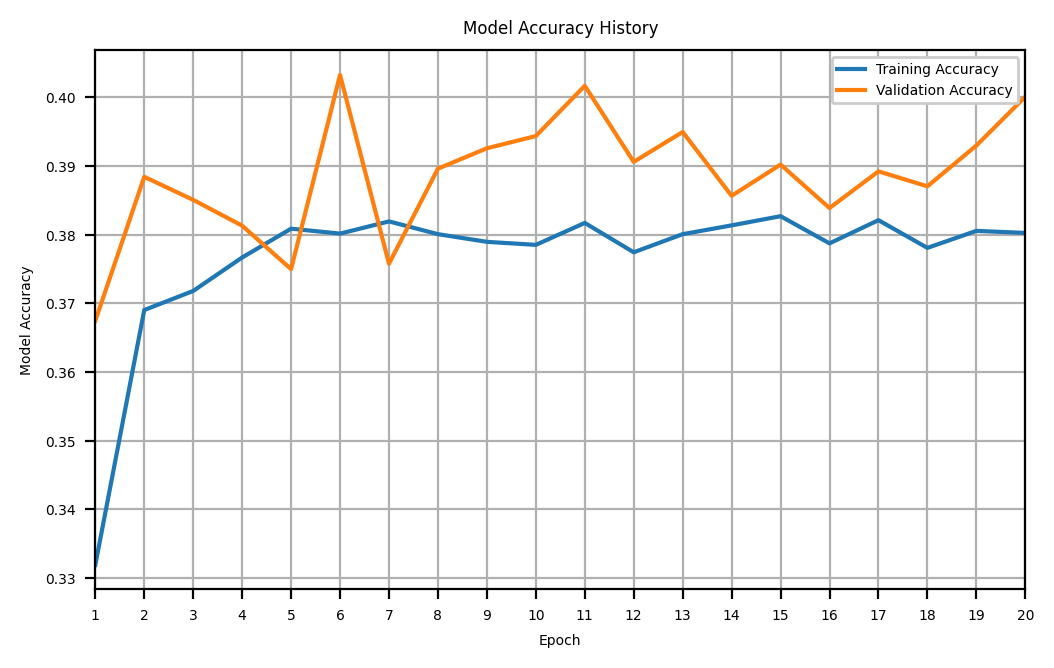

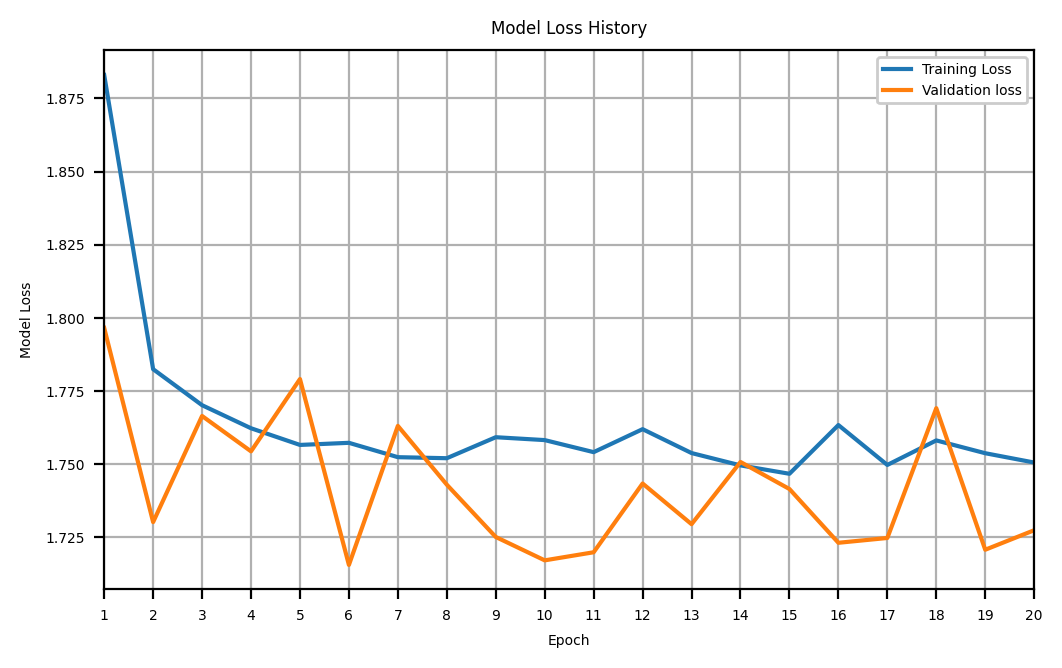

In [8]:
# create function to show model training accuracy and loss history
def model_history(history):
        # plot training history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train accuracy'])+1),
                history['train accuracy'],
                label = r'Training Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation accuracy"])+1),
                history['validation accuracy'],
                label = r'Validation Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Accuracy History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Accuracy')
        ax.set_xlim(1, len(history["train accuracy"]))
        ax.set_xticks(list(range(1,len(history["train accuracy"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

        # plot loss history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train loss'])+1),
                history['train loss'],
                label = r'Training Loss',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation loss"])+1),
                history['validation loss'],
                label = r'Validation loss',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Loss History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Loss')
        ax.set_xlim(1, len(history["train loss"]))
        ax.set_xticks(list(range(1,len(history["train loss"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

# plot training history using the function
model_history(trained_classifier)

We next define the `evaluation` function to evaluate the trained model on the `extracted_test_loader` dataset. Similar to our training loop, this function returns a dictionary of relevant items for analysis and further visual inspection. Namely:
1. Test set accuracy
2. Test set loss
3. Label predictions
4. True labels
5. Softmax probabilities

In [11]:
from sklearn.metrics import accuracy_score

def evaluate(model, test_loader):

    model.to(device)
    model.eval()
    softmax = nn.Softmax(dim=1).to(device)
    
    probs_list = []
    y_true = []
    
    test_loss = 0
    
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.append(labels)

        with torch.no_grad():
            
            # forward pass and loss on model
            linear_outputs = model(inputs)
            loss = criterion(linear_outputs, labels)

        # apply softmax layer
        outputs = softmax(linear_outputs)
        
        # add loss to total
        test_loss += loss.item()
        
        # append softmax probabilities to probs_list
        for prob, label in zip(outputs, labels):
            probs_list.append(prob.cpu().tolist())
            
    
    y_true = torch.cat(y_true, dim=0).cpu()
    
    # compute total loss on test set
    test_loss /= len(test_loader)
    
    # get predicitons
    y_pred = list(np.argmax(np.asarray(probs_list), axis = 1))
    
    # report accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    print("Test Accuracy:", accuracy)
    print("Test Loss: {:.4f}".format(test_loss))
    
    # return dictionary
    evaluation = {
        "accuracy": accuracy,
        "loss": test_loss,
        "y_pred": list(y_pred),
        "y_true": list(y_true),
        "probs": list(probs_list)
    }
    
    return evaluation
        
test_results = evaluate(trained_classifier["model"], test_loader)

100%|██████████| 79/79 [00:03<00:00, 23.59it/s]

Test Accuracy: 0.4066
Test Loss: 1.6948


In [12]:
import pandas as pd

def prediction_results(test_results: dict = test_results, test_set = test_set):
    
    # create dataframe from test results for data manipulation
    df = pd.DataFrame(test_results, columns = test_results.keys()).drop(["accuracy", "loss"], axis=1).reset_index()

    # add predicted and true labels to the dataframe
    df["pred_class"] = df["y_pred"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    df["true_class"] = df["y_true"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    # obtain predicted class probability
    df["pred_prob"] = df["probs"].apply(
        lambda x: np.max(x)
    )
    
    # create list of dataframes of top best and worst predictions
    best_predictions = []
    worst_predictions = []
    
    for label in list(CIFAR10_labels.keys()):
        
        # create dataframes of top 5 best and worst predictions
        best_prediction = df.query(str(label)+" == y_true == y_pred").sort_values(by="pred_prob", ascending=False).head(5)
        worst_prediction = df.query(str(label)+" == y_pred != y_true").sort_values(by="pred_prob", ascending=False).head(5)
        
        # append to list of predictions
        best_predictions.append(best_prediction)
        worst_predictions.append(worst_prediction)
    
    # define functino for plotting
    def plotter(df):
        fig = plt.figure(figsize=(10,2), dpi = 200)

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.4)

        for i, (idx, row) in enumerate(df.iterrows()):

            ax = fig.add_subplot(1, 5, i+1)
            ax.set_title(
                f"Predicted Class: {row[4]}\n"+
                f"True Class: {row[5]}\n"+
                f"Predicted Class Probability: {row[6]: .4f}"
            )
            
            ## print(CIFAR10_labels[test_set[idx][1]])
            
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            plt.imshow(img)
            
    for best_pred, worst_pred in zip(best_predictions, worst_predictions):
        plotter(best_pred)
        plotter(worst_pred)


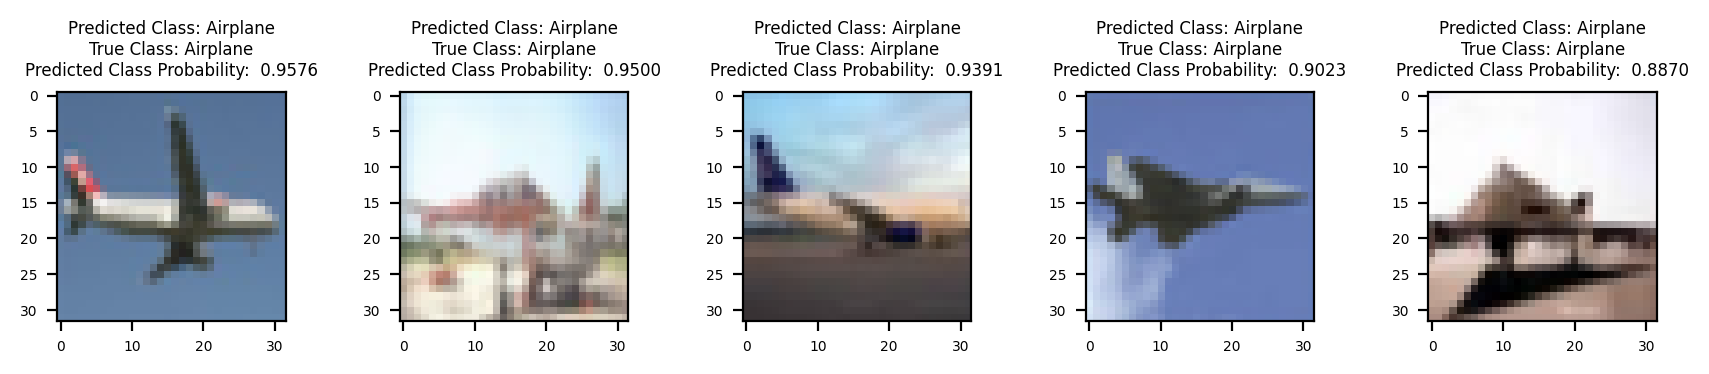

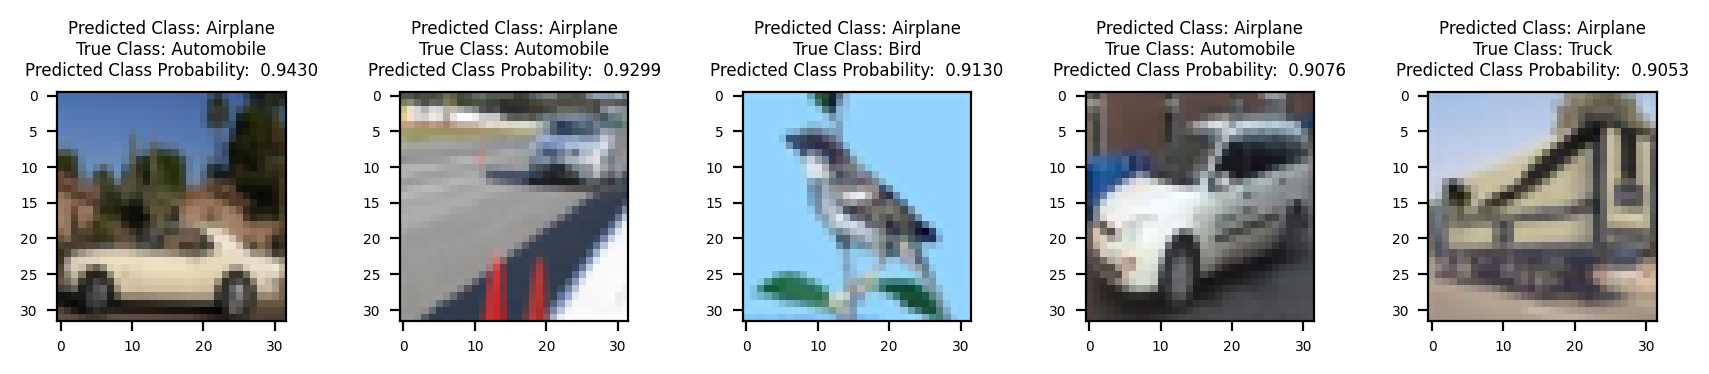

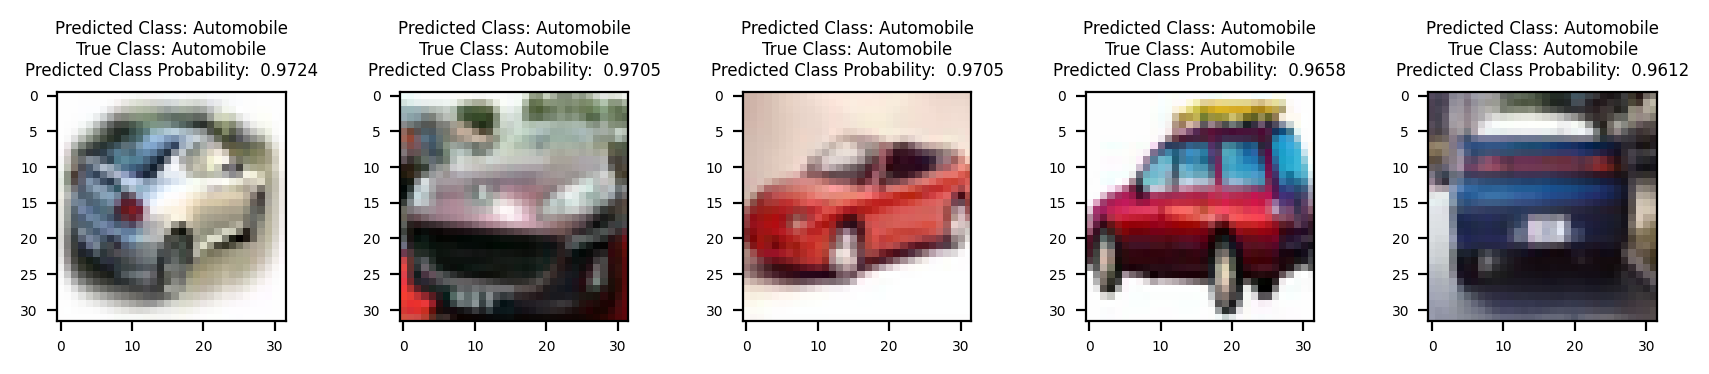

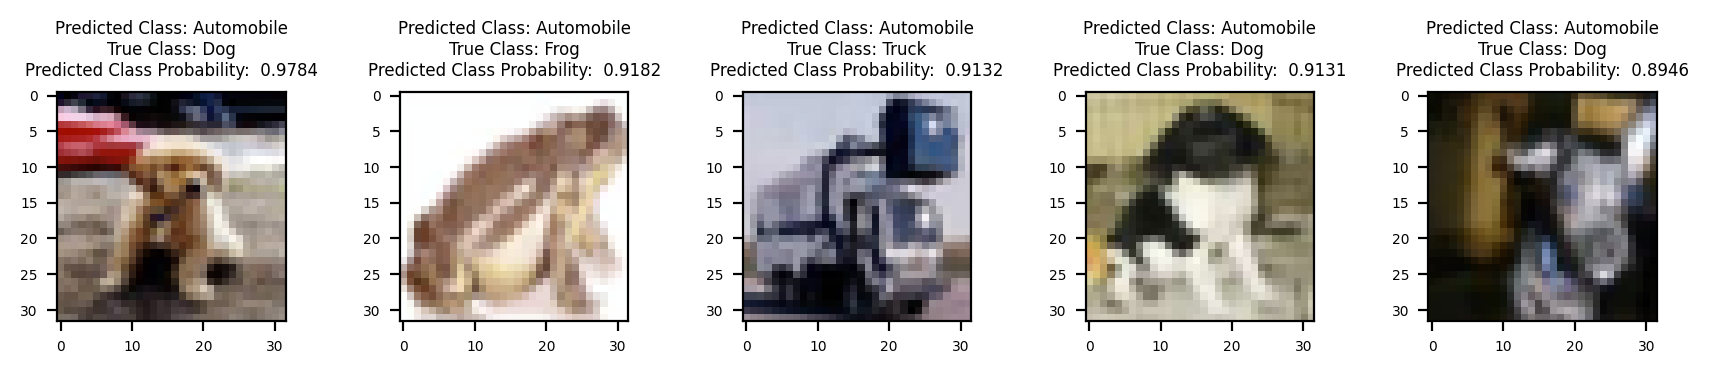

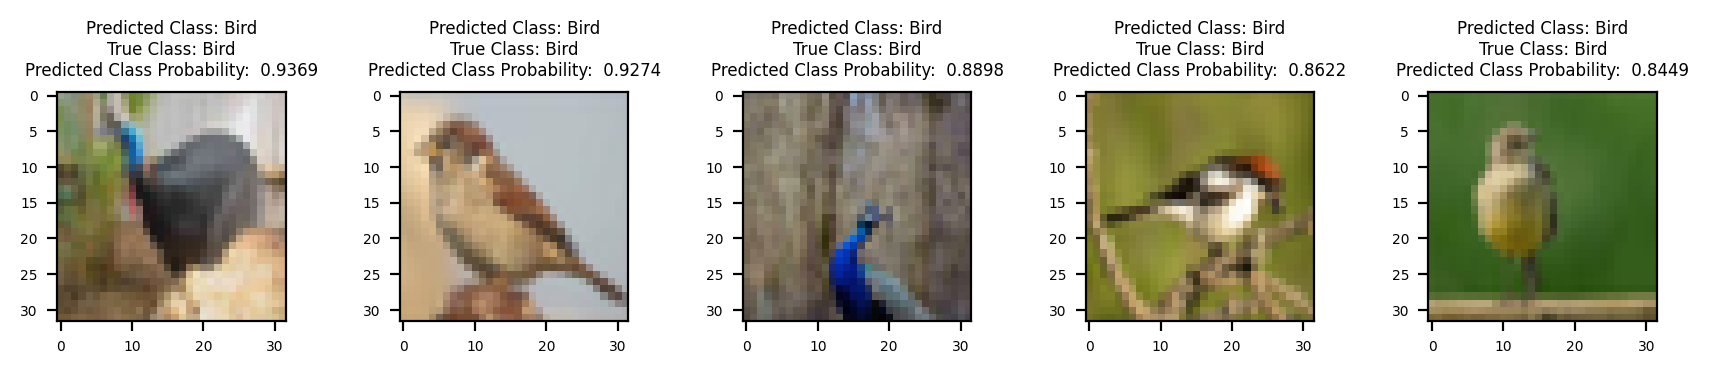

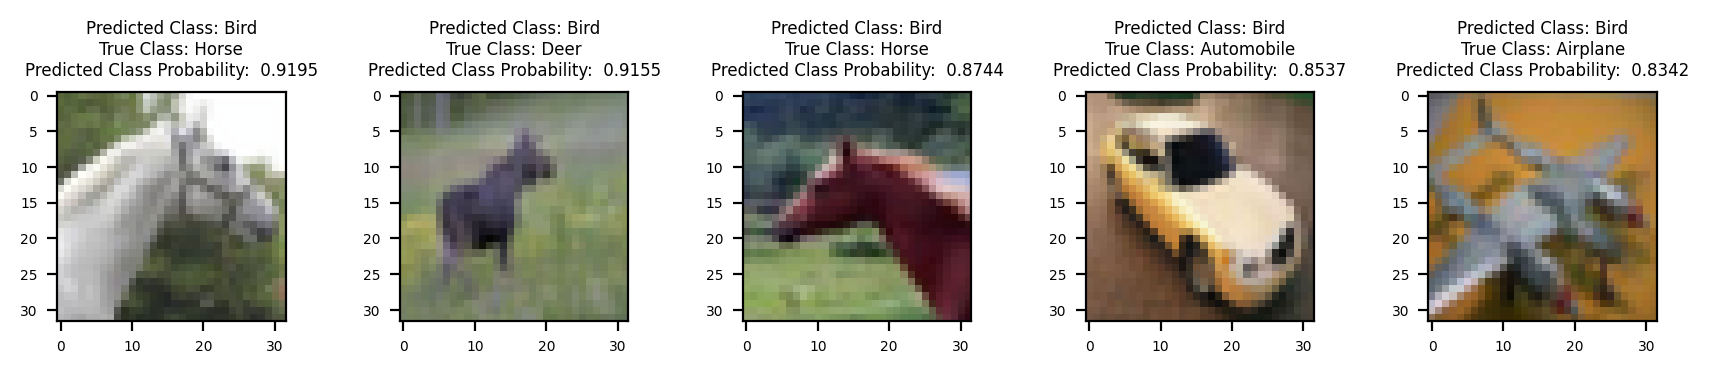

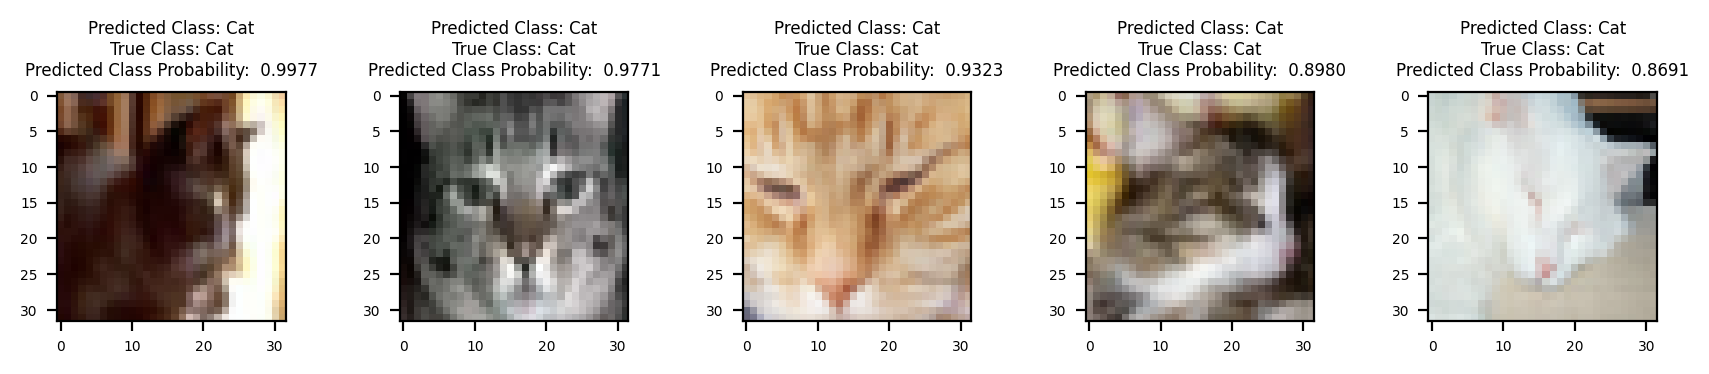

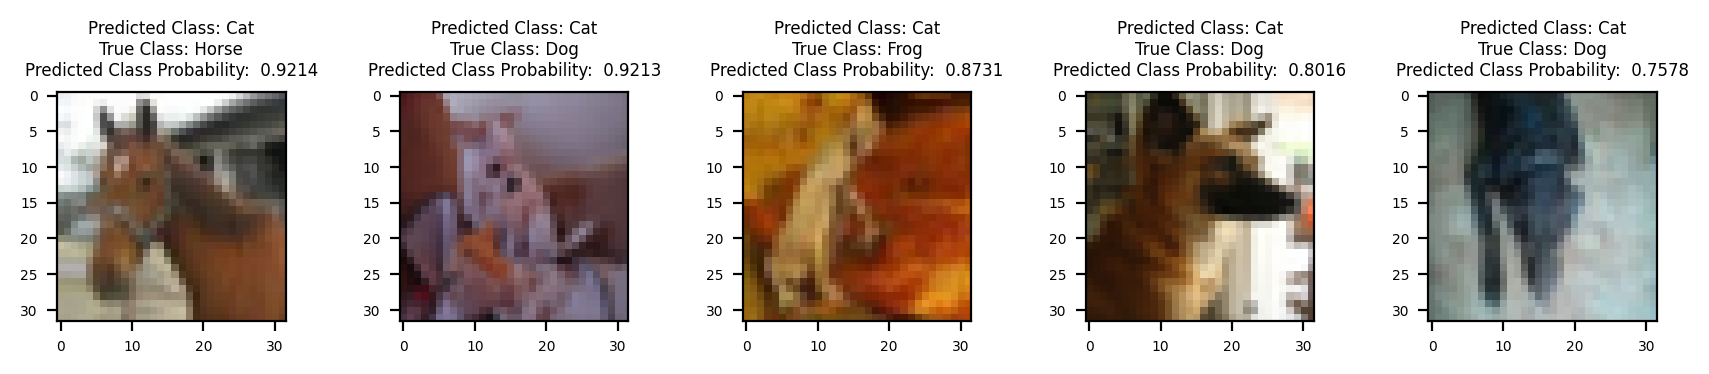

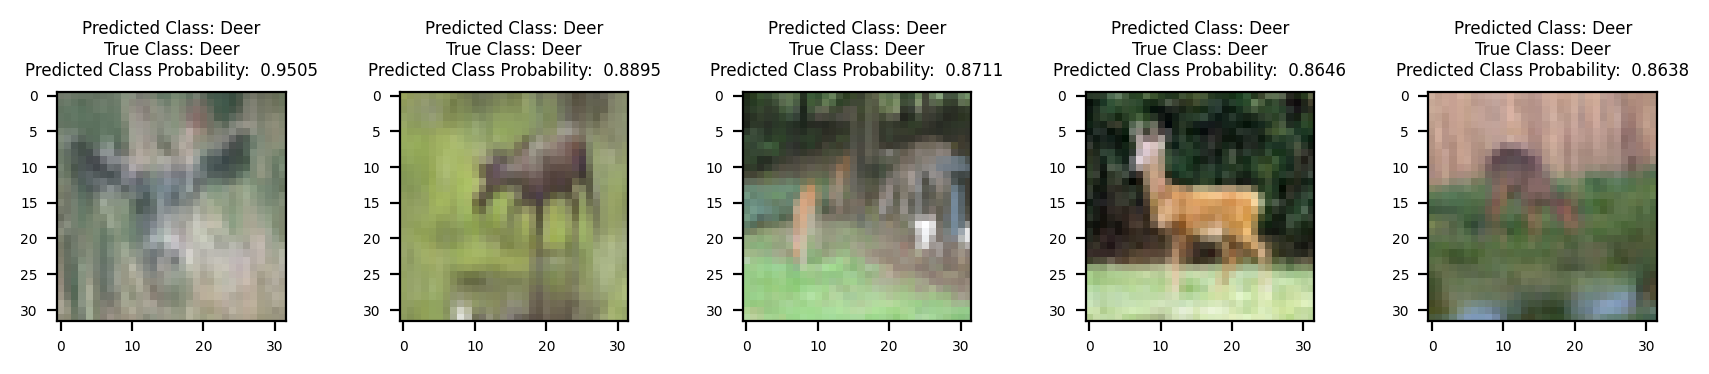

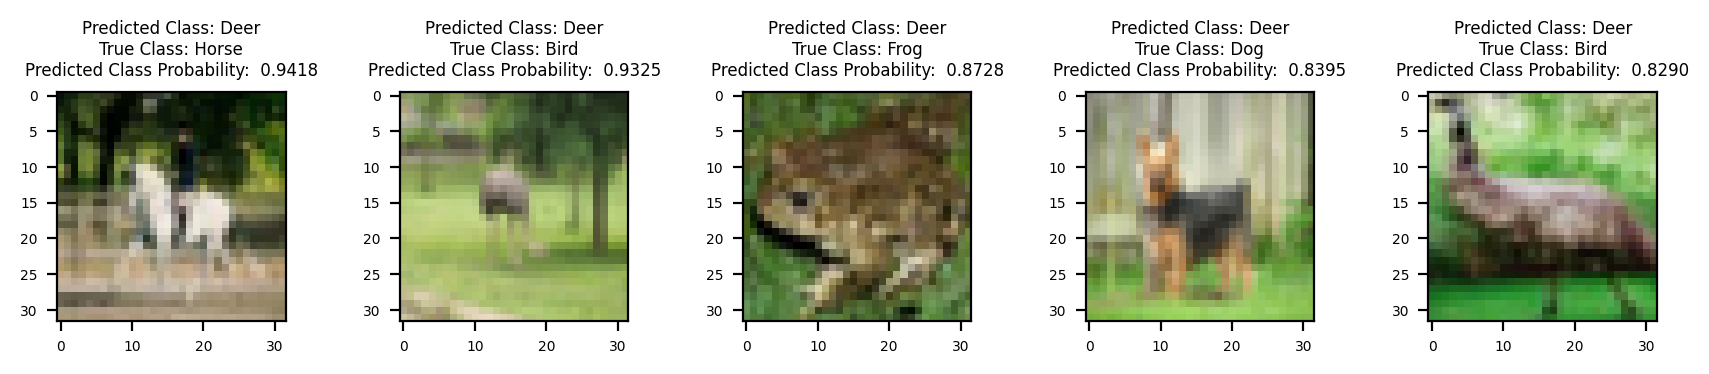

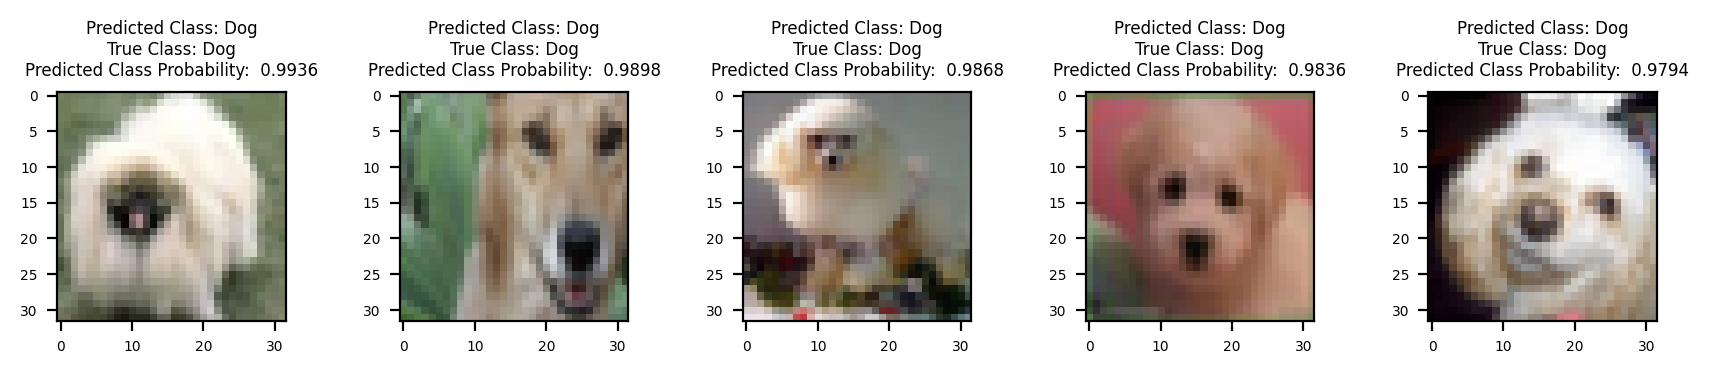

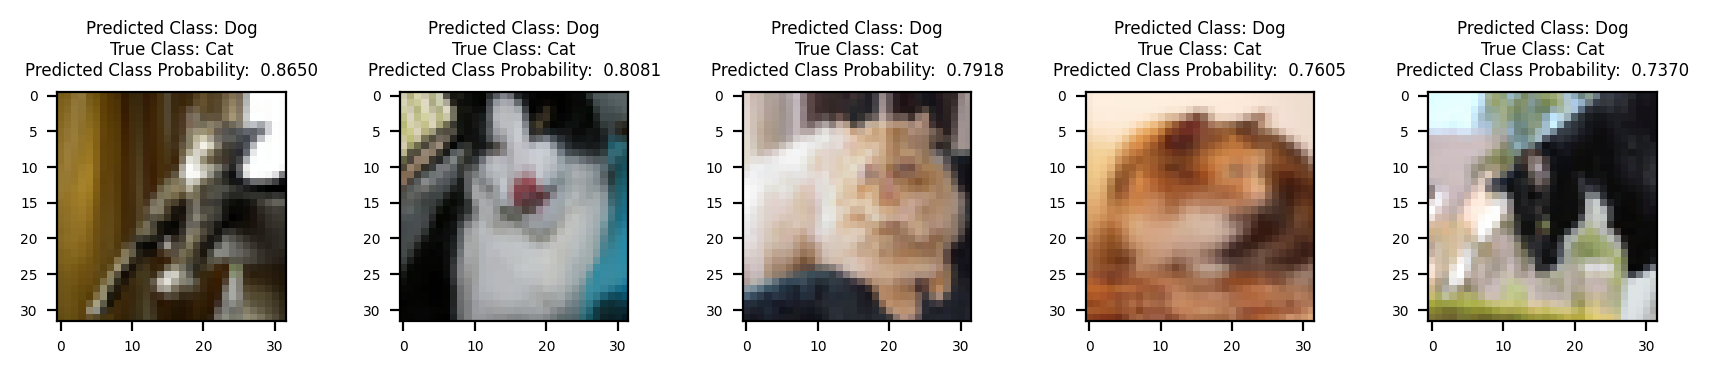

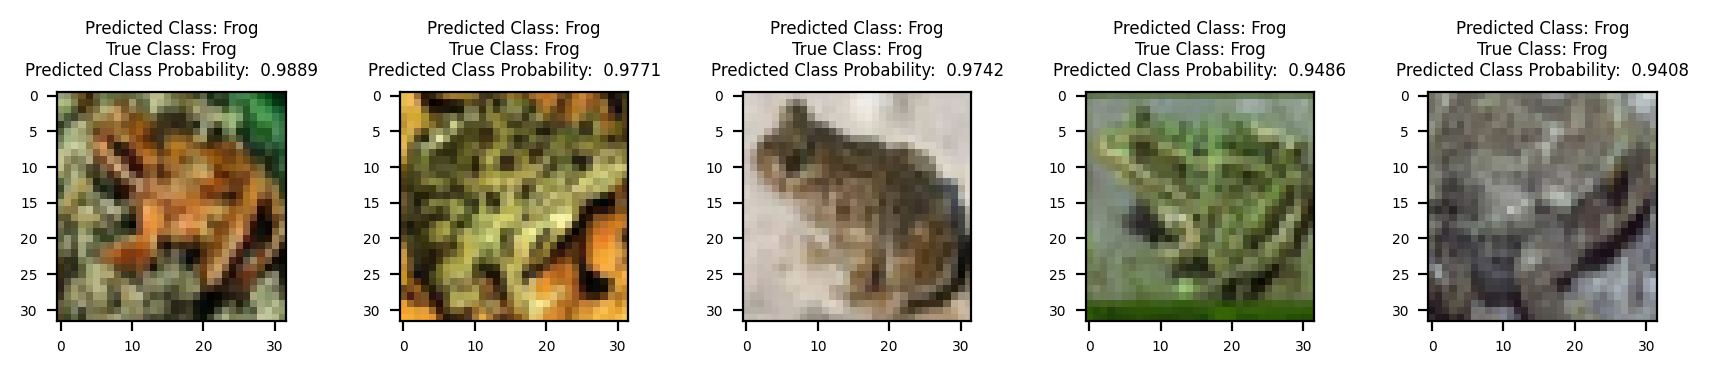

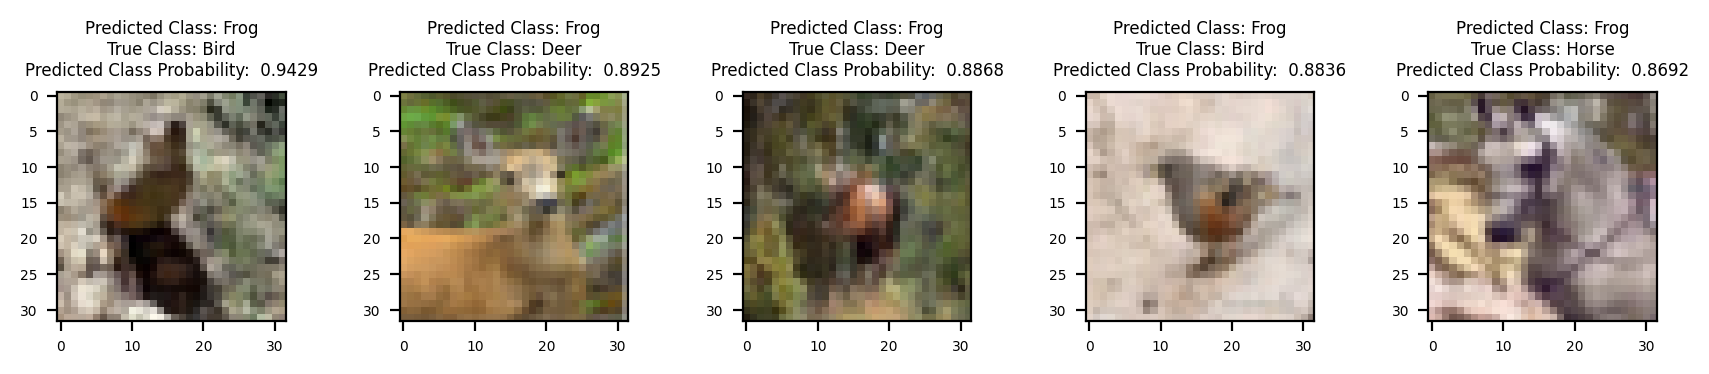

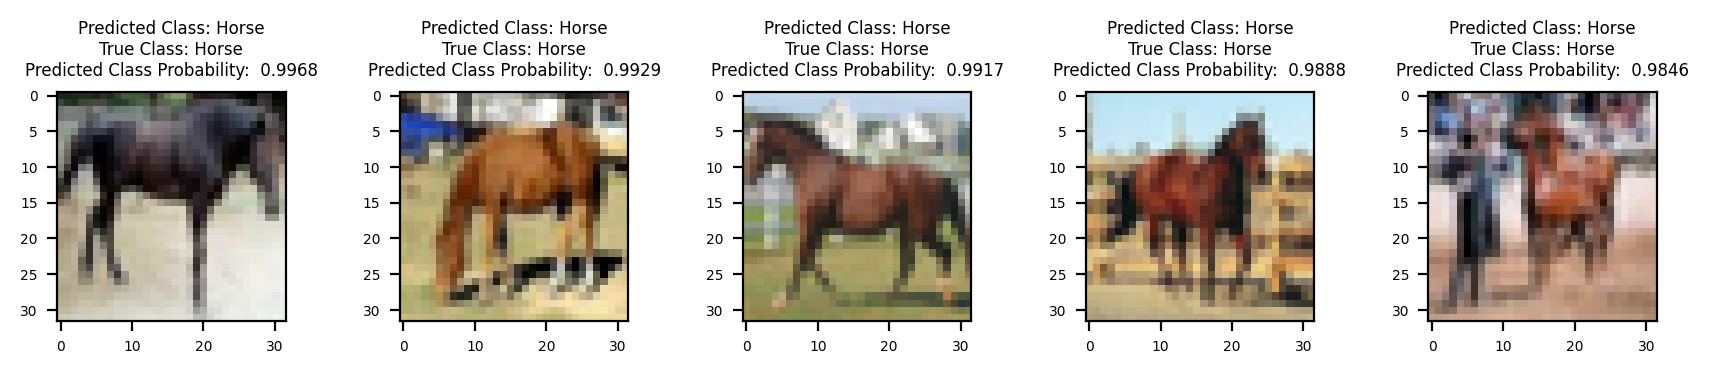

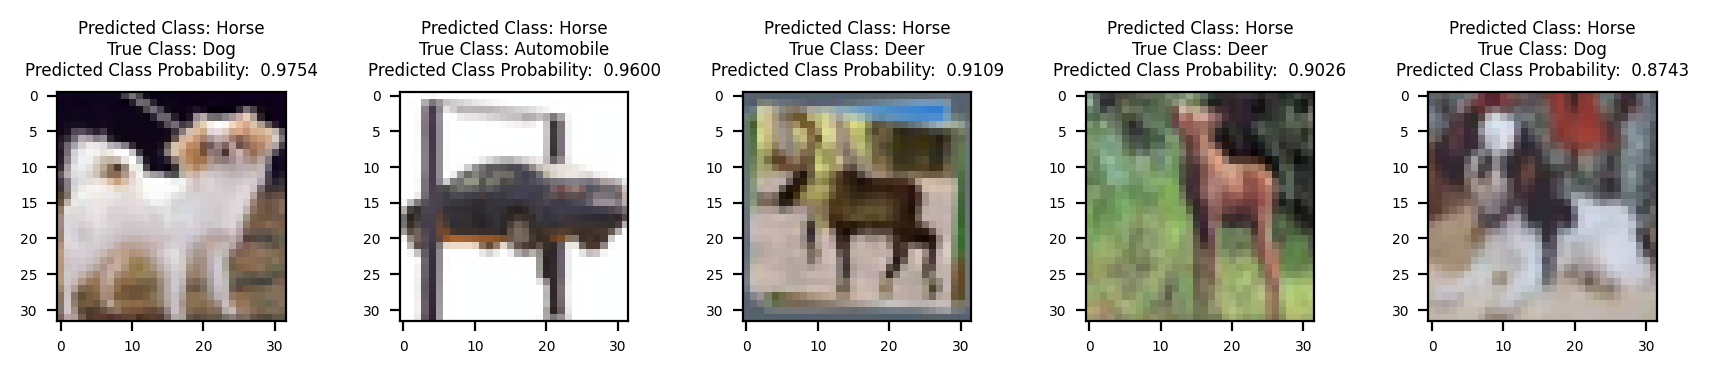

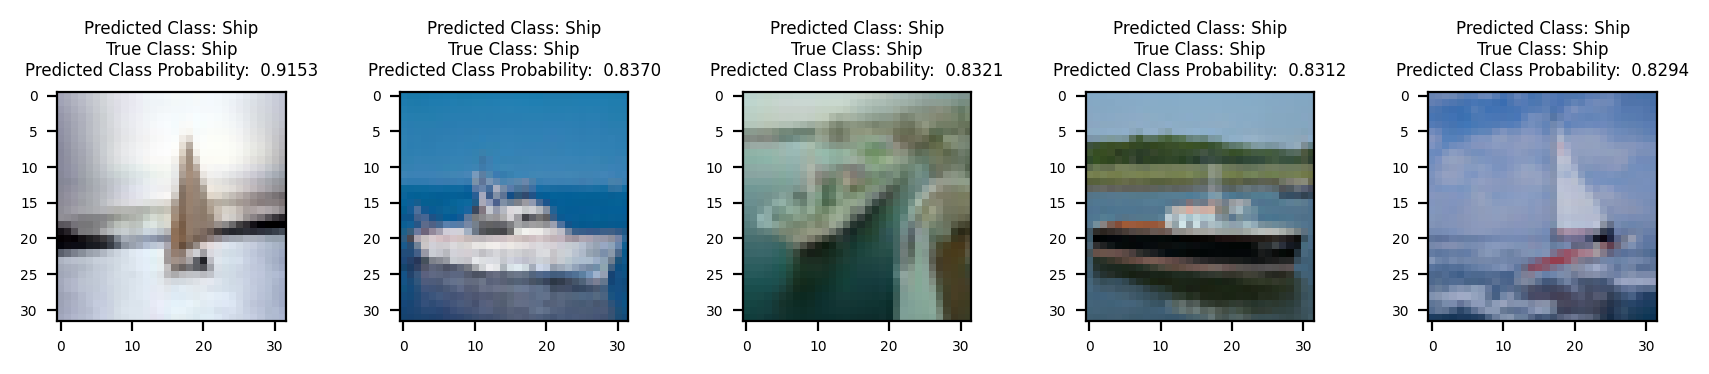

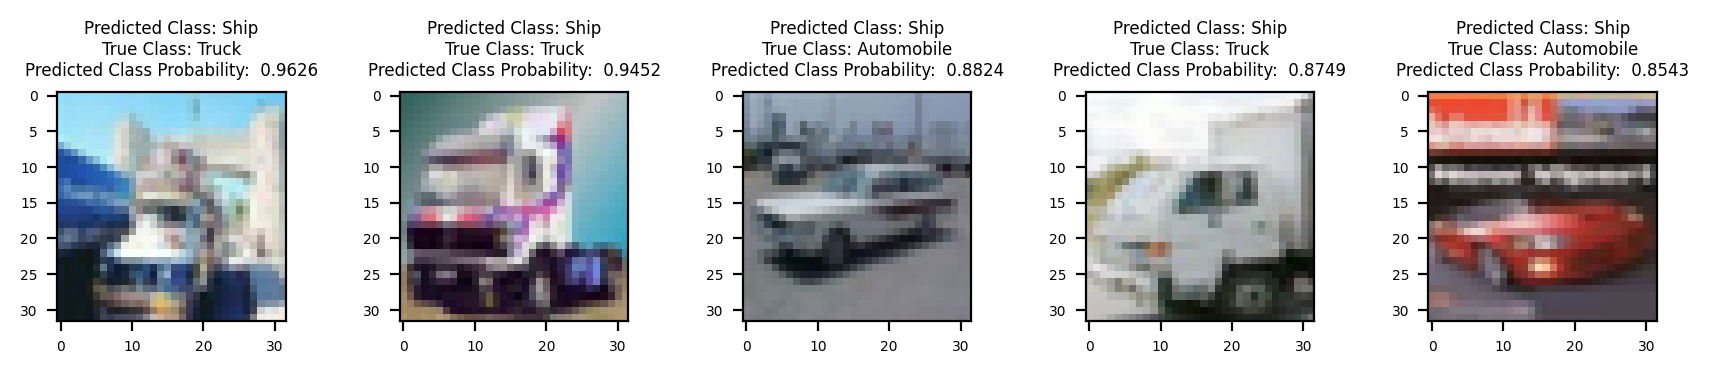

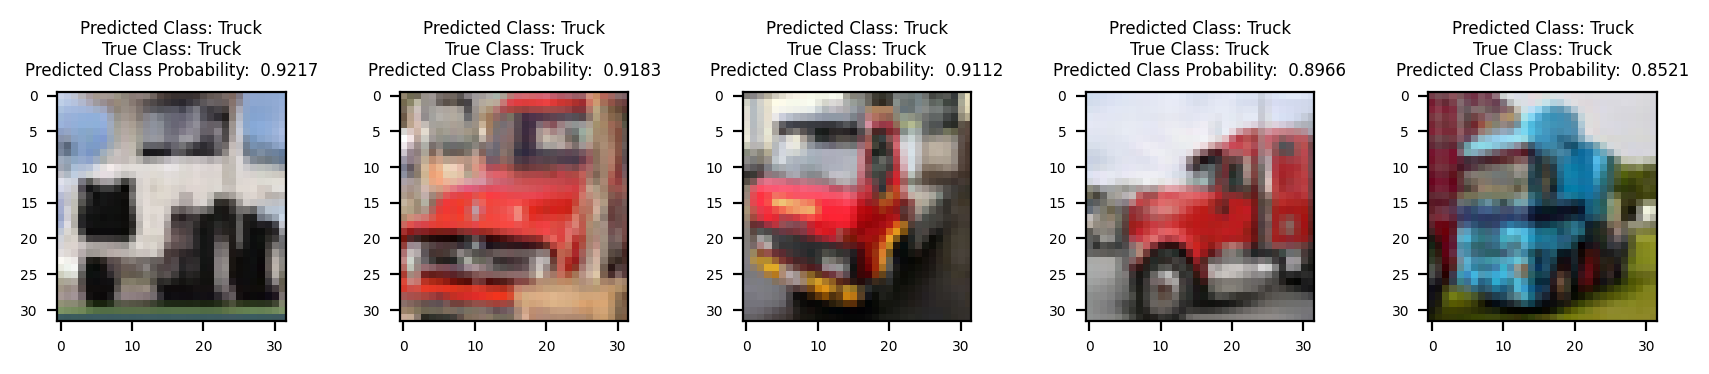

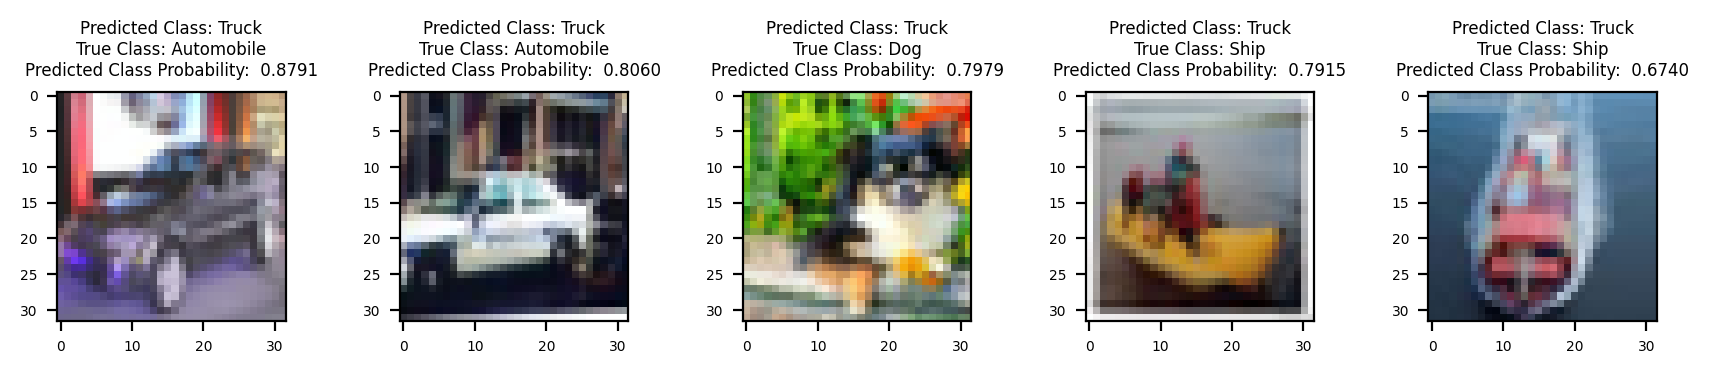

In [13]:
prediction_results(test_results, test_set)

# Fine-Tuning

## Fine-Tuning Preparation:
Make a copy of the pre-trained ResNet-18 model.
Modify the classifier (e.g., replace the final fully connected layer) for the new task (CIFAR-10).

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchsummary import summary

# Load the pre-trained ResNet-18 model
resnet18_model = resnet18(weights=True)

# Modify the final fully connected layer for your specific task (CIFAR-10 has 10 classes)
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, 10)  # 10 output classes for CIFAR-10

## Fine-Tuning:
Fine-tune the ResNet-18 model on the CIFAR-10 dataset.
Specify the appropriate hyperparameters (e.g., learning rate, number of epochs).

In [16]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)

# Load the model onto the appropriate device (e.g., GPU)
# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu") # we don't need this device is already set
resnet18_model.to(device)

'''

Please use the previously defined function train_model() to evaluate the fine-tune model

'''

# Fine-tuning: Training the modified ResNet-18 model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Print the average loss for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Train the model
train_model(resnet18_model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Loss: 1.2760146043032332
Epoch 2/10, Loss: 0.9274351893331084
Epoch 3/10, Loss: 0.8136904181726753
Epoch 4/10, Loss: 0.7371808615182062
Epoch 5/10, Loss: 0.6933582337463603
Epoch 6/10, Loss: 0.6422504461787241
Epoch 7/10, Loss: 0.6165568493973569
Epoch 8/10, Loss: 0.5844982931833438
Epoch 9/10, Loss: 0.5558740301510258
Epoch 10/10, Loss: 0.5383877990114719


# Model Evaluation:
Evaluate the feature extraction model and fine-tuned model on the test dataset.

In [17]:
# Evaluate the fine-tuned model on the test set
feature_extraction_results = evaluate(trained_classifier["model"], test_loader)

# Evaluate the fine-tuned model on the test set
fine_tuned_results = evaluate(resnet18_model, test_loader)

100%|██████████| 79/79 [00:03<00:00, 23.89it/s]


Test Accuracy: 0.4066
Test Loss: 1.6948


100%|██████████| 79/79 [00:03<00:00, 24.00it/s]

Test Accuracy: 0.8092
Test Loss: 0.5531


## Confusion matrix

In [29]:
def plot_confusion_matrix(model, test_loader, class_labels):
    """
    Plot the confusion matrix for a model's predictions on a test dataset.
    Args:
        model: The trained model for which you want to create a confusion matrix.
        test_loader: DataLoader for the test dataset.
        class_labels: List of class labels for mapping the confusion matrix.
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    


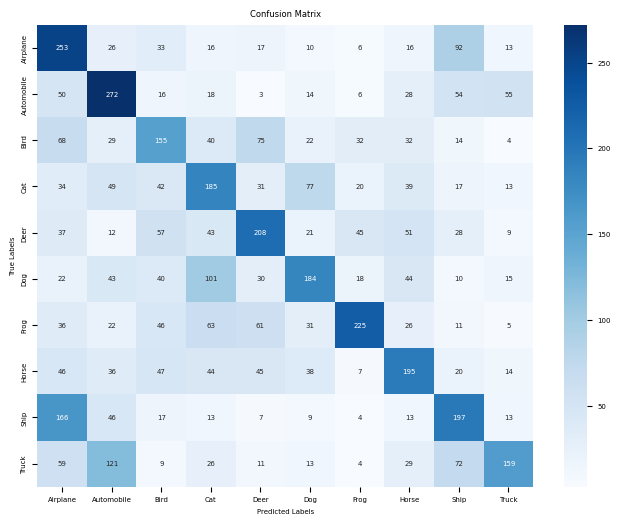

In [30]:
# Define class labels for CIFAR-10
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Generate confusion matrix for logistic regression model
plot_confusion_matrix(trained_classifier["model"], test_loader, class_labels)


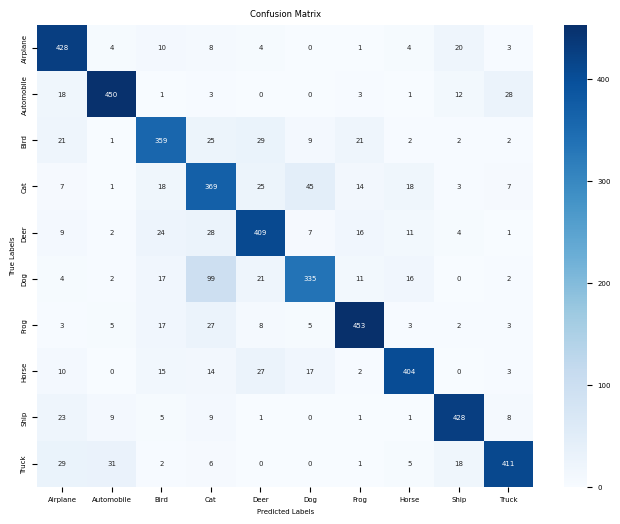

In [31]:
# Generate confusion matrix for fine-tuned ResNet-18 model
plot_confusion_matrix(resnet18_model, test_loader, class_labels)